<a href="https://colab.research.google.com/github/Sernikjamnika/garbage_classifier/blob/master/Garbage_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Garbage classification
This notebook consists attempt to classify grabage based on given image. As we now people are terrible if it comes to garbage segregation. Let's see if DL can halep them!

## Download of data



In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [0]:
from google.colab import files
files.upload()

In [0]:
!cp kaggle.json ~/.kaggle/

In [0]:
!kaggle datasets download -d asdasdasasdas/garbage-classification

 89% 36.0M/40.6M [00:01<00:00, 20.5MB/s]
100% 40.6M/40.6M [00:01<00:00, 29.0MB/s]


In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
!unzip -q "garbage-classification.zip"

In [0]:
!unzip -q "Garbage classification.zip"

Data is divided into train, validation and test dataset based on given `.txt` files

In [0]:
import os
import sys
import re

In [0]:
datasets = ['train', 'test', 'val']
for dataset in datasets:
    if not os.path.exists(f'{dataset}'):
        os.mkdir(dataset)
    with open(f'one-indexed-files-notrash_{dataset}.txt') as file:
        for row in file.readlines():
            img_name, label = row.split()
            label_name = re.match('(\D+)\d+.jpg', img_name).group(1)
            if not os.path.exists(f'{dataset}/{label_name}'):
                os.mkdir(f'{dataset}/{label_name}')
            os.rename(f'Garbage classification/{label_name}/{img_name}',
                      f'{dataset}/{label_name}/{img_name}')
    

In [0]:
!rm -r "Garbage classification" "garbage-classification.zip" "Garbage classification.zip";

**NOTE**: If you have already downloaded dataset on gdrive you should use only those

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


## Looking at data and applying transformations

In [0]:
import fastai
import fastai.vision
import numpy as np
%reload_ext autoreload
%autoreload 2
%matplotlib inline

data_path = '/gdrive/My Drive/n-waves/garbage_classification/'
np.random.seed(42)

In [0]:
data = fastai.vision.data.ImageDataBunch.from_folder(path=data_path, 
                                                     valid='val',
                                                     test='test',
                                                     ds_tfms=fastai.vision.get_transforms(),
                                                     size=224,
                                                     bs=32
                                                    ).normalize(fastai.vision.imagenet_stats)

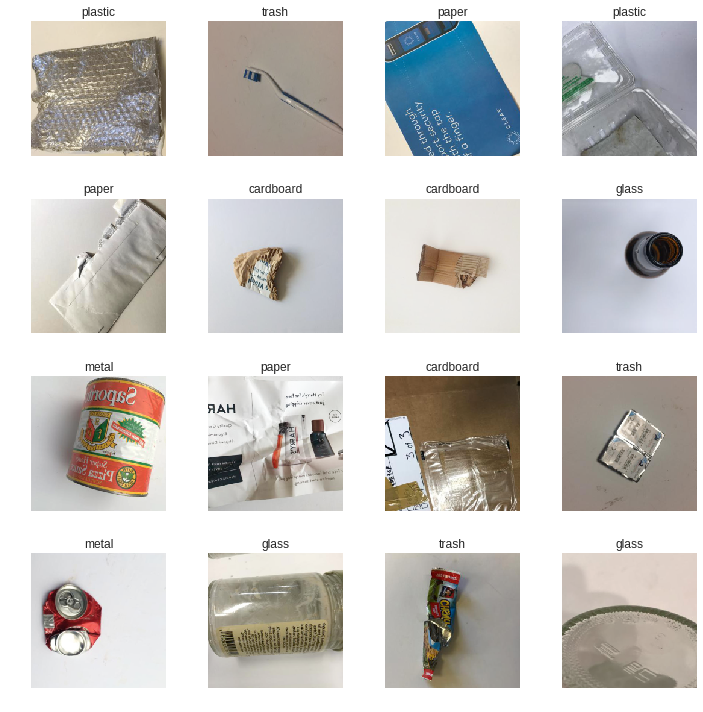

In [0]:
data.show_batch(rows=4, figsize=(10,10))

In [0]:
print(data.classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [0]:
learner = fastai.vision.create_cnn(data, 
                                   fastai.vision.models.resnet34, 
                                   metrics=fastai.metrics.error_rate)

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:105: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
87306240it [00:01, 51161158.99it/s]


In [0]:
learner.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.240006,0.544427,0.179878,05:01
1,0.801937,0.483528,0.167683,00:36
2,0.589517,0.430298,0.152439,00:36
3,0.455948,0.408145,0.140244,00:35


In [0]:
learner.save(f'{data_path}/models/resnet34_1')

## Interpretation of results

In [0]:
interpreter = fastai.vision.learner.ClassificationInterpretation.from_learner(learn=learner)
losses, indexs = interpreter.top_losses()

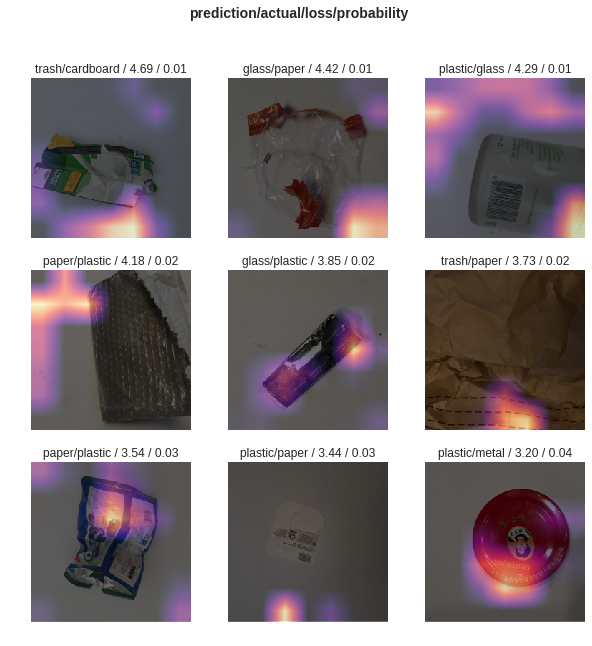

In [0]:
interpreter.plot_top_losses(9, figsize=(10, 10))

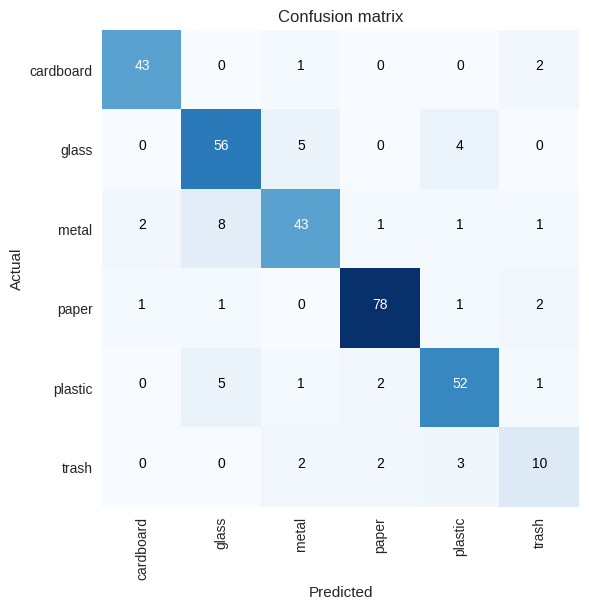

In [0]:
interpreter.plot_confusion_matrix(figsize=(6, 6), dpi=100)

In [0]:
import numpy as np
conf_matrix = interpreter.confusion_matrix()
def calculate_accuracy_for_classes(conf_matrix, classes):
    result = {}
    for index, (row, class_name) in enumerate(zip(conf_matrix, classes)):
        accuracy = row[index] / np.sum(row)
        result[class_name] = accuracy
    return result
classes_acc = calculate_accuracy_for_classes(conf_matrix, data.y.classes)

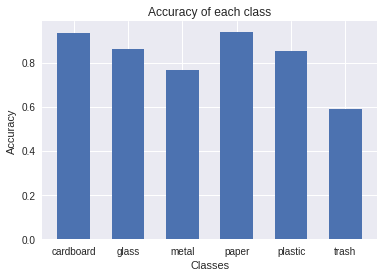

In [0]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.bar(x=classes_acc.keys(), height=classes_acc.values(), width=0.6)
plt.title("Accuracy of each class")
plt.ylabel("Accuracy")
plt.xlabel("Classes")
fig.show()

As we can see see `trash` is the class which is classified the worst. While we can see that `paper` and `cardborad` are recognized the most accurately. In next section we will try to make the accruacy higher. Looking at the dataset it's caused by weak definition of what trash is. There we can see candy wrappers or empty bag of crisps. These probably would be qualified as plastic by every person. True trash like apple core or banana skin are the minority in this class. Probably enhacing this dataset would work but we will try doing this later.



## Fine - tuning the model

 

In [0]:
learner.load(f"{data_path}/models/resnet34_1")

In [0]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


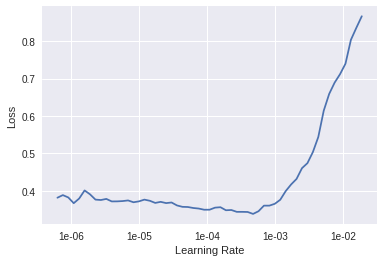

In [0]:
learner.recorder.plot()

In [0]:
learner.unfreeze()
learner.fit_one_cycle(4, slice(1e-6, 3 * 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.377014,0.382888,0.125000,00:36
1,0.362826,0.359461,0.100610,00:37
2,0.303033,0.343313,0.109756,00:37
3,0.264941,0.340924,0.115854,00:36


As we can see the error rate has gone down but still remains high. It is possible that more complicated model can get better performance. That is why I will try to use ResNet50.

## More complicated model

In [0]:
data = fastai.vision.ImageDataBunch.from_folder(path=f'{data_path}', 
                                             valid='val',
                                             test='test',
                                             ds_tfms=fastai.vision.get_transforms(),
                                             size=320,
                                             bs=16
                                            ).normalize(fastai.vision.imagenet_stats)

In [0]:
learner_50 = fastai.vision.cnn_learner(data,
                                      fastai.vision.models.resnet50,
                                      metrics=fastai.metrics.error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:04<00:00, 21486879.65it/s]


In [0]:
learner_50.fit_one_cycle(8, max_lr=1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.071096,0.501428,0.185976,05:06
1,0.689950,0.415108,0.152439,01:09
2,0.626373,0.362825,0.128049,01:10
3,0.487702,0.300270,0.109756,01:10
4,0.390945,0.273282,0.091463,01:09
5,0.338098,0.236599,0.076220,01:10
6,0.271700,0.239142,0.070122,01:10
7,0.261360,0.242460,0.070122,01:09


In [0]:
learner_50.save(f"{data_path}/models/resnet50_1")

In [0]:
learner_50.load(f"{data_path}/models/resnet50_1")

In [0]:
learner_50.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


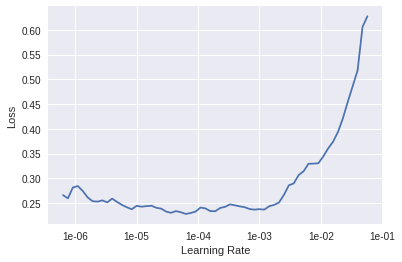

In [0]:
learner_50.recorder.plot()

In [0]:
learner_50.unfreeze()
learner_50.fit_one_cycle(2, slice(1e-6, 3*1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.265305,0.221281,0.073171,01:25
1,0.223123,0.226198,0.064024,01:21


What is going to happen if I unfreeze once more?


In [0]:
learner_50.unfreeze()
learner_50.fit_one_cycle(2, slice(1e-6, 3*1e-4))

In [0]:
interpreter_50 = fastai.vision.ClassificationInterpretation.from_learner(learner_50)
interpreter_50.most_confused()

[('plastic', 'glass', 5),
 ('glass', 'metal', 2),
 ('metal', 'plastic', 2),
 ('paper', 'cardboard', 2),
 ('paper', 'trash', 2),
 ('plastic', 'trash', 2),
 ('glass', 'plastic', 1),
 ('metal', 'cardboard', 1),
 ('paper', 'metal', 1),
 ('plastic', 'paper', 1),
 ('trash', 'cardboard', 1),
 ('trash', 'paper', 1)]

In [0]:
learner_50.save(f"{data_path}/models/resnet50_2")

It is truly visible that after taking complicated model and retrainging it the results are twice as good as with `Resnet34`. From the level of 14% of error rate we got 6%.

## Testing on real life examples

In [0]:
!mkdir /gdrive/"My Drive"/n-waves/garbage_classification/life_examples

trash bag.jpg
metal plastic.jpg
plastic bottles.jpg
paper organic.jpg
metal metal_trash.jpeg
metal cup.jpeg
paper cup2.jpg
cardboard 53766610_1261655347321255_576746642506514432_n.jpg
cardboard 53918406_295327727805223_3598630196829224960_n.jpg
plastic 53906771_822510974780054_119602396673343488_n.jpg


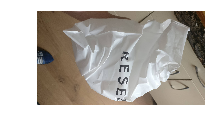

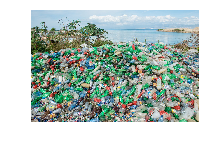

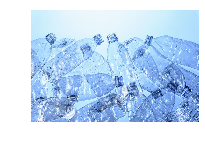

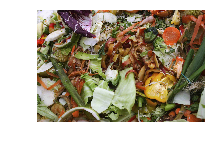

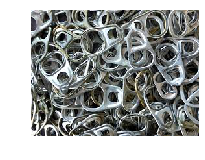

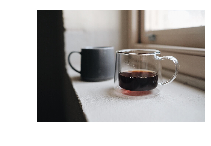

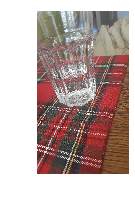

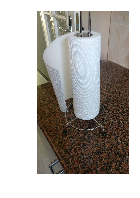

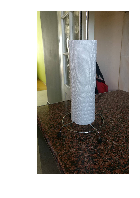

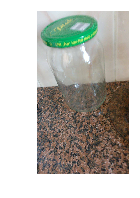

In [0]:
import os
images = [f for f in os.listdir(data_path+'/life_examples')]

for image in images:
    img = fastai.vision.open_image(f'{data_path}/life_examples/{image}')
    img.show()
    print(learner_50.predict(img)[0], image)

trash trash40.jpg
cardboard cardboard363.jpg
glass glass155.jpg
glass glass493.jpg
trash trash45.jpg
metal metal209.jpg
paper paper208.jpg
trash trash101.jpg


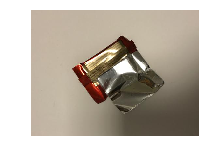

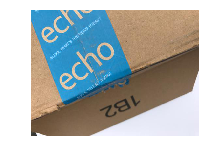

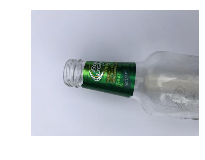

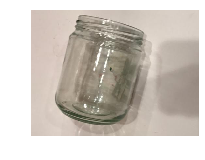

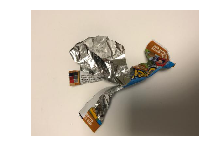

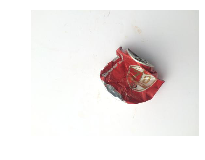

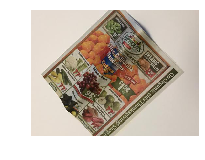

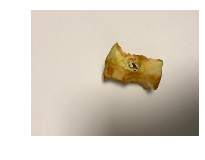

In [0]:
import random
images = [f for f in os.listdir(data_path+'test')]
classes = ['metal', 'trash', 'glass', 'paper', 'cardboard']

for _ in range(8):
    class_name = random.choice(classes)
    image_name = random.choice(os.listdir(data_path+'test'+'/'+class_name))
    img = fastai.vision.open_image(f'{data_path}test/{class_name}/{image_name}')
    img.show()
    print(learner_50.predict(img)[0], image_name)

## Experiments with learning rate
Those experiments will be based on architecture using re-trained resnet50 (from file resnet50_1)

In [0]:
learner_50.load(f"{data_path}/models/resnet50_1")

In [0]:
learner_50.lr_find()

We are going to plot the loss by learning rate. Then we will experiment a bit with possible assumptions taken from it. 

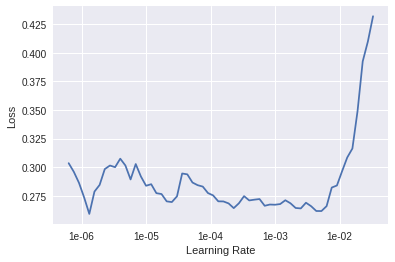

In [0]:
learner_50.recorder.plot()

Let us notice that the global minimum is at the point 1e-06. We want to check how our lerner will behave with such a learning rate.


In [0]:
learner_50.load(f"{data_path}/models/resnet50_1")
learner_50.unfreeze()
learner_50.fit_one_cycle(10, max_lr=1e-6)

epoch,train_loss,valid_loss,error_rate,time
0,0.264265,0.320116,0.106707,00:50
1,0.250361,0.324733,0.115854,00:50
2,0.241205,0.314572,0.109756,00:49
3,0.246817,0.315991,0.106707,00:49
4,0.235863,0.305969,0.115854,00:49
5,0.238601,0.300043,0.100610,00:50
6,0.231078,0.301237,0.106707,00:50
7,0.233933,0.301798,0.112805,00:49
8,0.225049,0.299695,0.103659,00:49
9,0.232125,0.294782,0.103659,00:50


We can notice that the error_rate ramins the same with little variation. It means that our model is not learning at all or it does it really slowly. We can suspect that it has stucked in local miminimum of the loss function and can not find global one.

Now let's try the minimum before the explosion of loss. Additionaly it is local minimum. Learning rate equals 5 * 1e-2. Thanks to this fact maybe we will not stuck in local minimum 

In [0]:
learner_50.load(f"{data_path}/models/resnet50_1")
learner_50.unfreeze()
learner_50.fit_one_cycle(10, max_lr=5*1e-2)

epoch,train_loss,valid_loss,error_rate,time
0,1.873827,423.362793,0.786585,01:24
1,2.290908,2.812940,0.780488,01:23
2,2.648483,431.373047,0.774390,01:23
3,2.241143,370.707397,0.817073,01:23
4,2.047932,431.805969,0.817073,01:23
5,1.833295,1.690094,0.713415,01:23
6,1.668127,1.650521,0.695122,01:23
7,1.559588,2.297016,0.557927,01:22
8,1.483088,1.369444,0.533537,01:22
9,1.437432,1.344570,0.554878,01:21


Something unexpected happend! In some points the validation loss has exploded! What is more we started with much grater error_rate than previous example.

Ok. So the perfect value should be somewhere in the middle. I think that `1e-3` can be better than  previous attempts. It is magnitude smaller than `1e-2` and much bigger than `1e-6`.

In [0]:
learner_50.load(f"{data_path}/models/resnet50_1")
learner_50.unfreeze()
learner_50.fit_one_cycle(10, max_lr=1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.346775,0.631699,0.170732,00:50
1,0.559192,2.496653,0.402439,00:50
2,0.684977,3.527490,0.503049,00:50
3,0.622933,1.480932,0.368902,00:49
4,0.600915,0.597753,0.198171,00:50
5,0.520025,0.473709,0.140244,00:49
6,0.359322,0.342365,0.112805,00:49
7,0.266519,0.251775,0.076220,00:50
8,0.188800,0.196082,0.057927,00:50
9,0.126562,0.193616,0.057927,00:49


In [0]:
learner_50.load(f"{data_path}/models/resnet50_1")
learner_50.unfreeze()
learner_50.fit_one_cycle(10, max_lr=slice(5 * 1e-4, 1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.296433,0.388895,0.112805,07:58
1,0.495412,3.729245,0.557927,00:49
2,0.549496,0.484785,0.179878,00:50
3,0.506944,0.550063,0.213415,00:51
4,0.394709,0.568330,0.152439,00:50
5,0.325264,0.258483,0.082317,00:50
6,0.236369,0.250807,0.088415,00:50
7,0.175872,0.220646,0.067073,00:50
8,0.115008,0.158527,0.045732,00:50
9,0.083566,0.157985,0.048780,00:50


In [0]:
learner_50.load(f"{data_path}/models/resnet50_1")
learner_50.unfreeze()
learner_50.fit_one_cycle(10, max_lr=1e-10)

epoch,train_loss,valid_loss,error_rate,time
0,0.271392,0.322781,0.118902,00:50
1,0.273751,0.321346,0.115854,00:51
2,0.272272,0.324127,0.121951,00:51
3,0.263062,0.323897,0.125000,00:50
4,0.263993,0.326037,0.125000,00:51
5,0.280293,0.323354,0.118902,00:50
6,0.268143,0.327567,0.125000,00:50
7,0.255554,0.328776,0.125000,00:50
8,0.275771,0.334998,0.121951,00:50
9,0.257046,0.338181,0.121951,00:50


Now because of  **too small** value of learning rate the error rate stays the same. It has not got nor better neither worse.

In [0]:
learner_50.load(f"{data_path}/models/resnet50_1")
learner_50.unfreeze()
learner_50.fit_one_cycle(10, max_lr=slice(1e-2, 1e-1))

epoch,train_loss,valid_loss,error_rate,time
0,1.415150,61.536812,0.804878,00:50
1,2.189528,239013.906250,0.814024,00:51
2,3.070651,425.192535,0.753049,00:50
3,3.168709,75.877632,0.810976,00:50
4,2.801438,258.592621,0.780488,00:51
5,2.444115,1.592740,0.710366,00:50
6,2.036051,166.049530,0.722561,00:49
7,1.760183,314.535919,0.655488,00:49
8,1.627035,37.051357,0.573171,00:50
9,1.497819,37.738495,0.576219,00:50


In [0]:
learner_50.load(f"{data_path}/models/resnet50_1")
learner_50.unfreeze()
learner_50.fit_one_cycle(5, max_lr=slice(5 * 1e-4, 1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.477479,2.007395,0.399390,00:48
1,0.667784,0.601977,0.204268,00:48
2,0.490268,0.364083,0.125000,00:49
3,0.309731,0.242469,0.082317,00:49
4,0.191868,0.202808,0.064024,00:49


## More cycles
Let's take the best approach tested and lets make more cycles!

In [0]:
learner_50.load(f"{data_path}/models/resnet50_1")
learner_50.unfreeze()
learner_50.fit_one_cycle(20, max_lr=slice(5 * 1e-4, 1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.257852,0.260421,0.097561,00:50
1,0.224806,0.455185,0.131098,00:49
2,0.350729,1.104386,0.268293,00:50
3,0.533765,1.228405,0.314024,00:50
4,0.541739,0.527655,0.164634,00:50
5,0.476725,0.987697,0.307927,00:50
6,0.453832,0.630056,0.189024,00:49
7,0.394912,0.448264,0.134146,00:49
8,0.349593,0.469521,0.152439,00:49
9,0.345006,0.453558,0.140244,00:50


This can be surprising! Despite the fact we gave the model more cycles of learning the result is the same (or rather similar)! 

In [0]:
learner_50.load(f"{data_path}/models/resnet50_1")
learner_50.unfreeze()
learner_50.fit_one_cycle(10, max_lr=slice(5 * 1e-4, 1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.326795,0.432074,0.134146,00:50
1,0.518460,1.412629,0.289634,00:50
2,0.539049,0.546946,0.176829,00:50
3,0.505263,0.372408,0.128049,00:50
4,0.426560,0.421779,0.152439,00:49
5,0.340390,0.367822,0.100610,00:50
6,0.260414,0.362106,0.097561,00:50
7,0.163994,0.215731,0.064024,00:50
8,0.089844,0.223376,0.064024,00:50
9,0.066197,0.218152,0.054878,00:49


In [0]:
learner_50.load(f"{data_path}/models/resnet50_1")
learner_50.unfreeze()
learner_50.fit_onet_cycle(20, max_lr=slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.273231,0.293058,0.106707,00:49
1,0.234423,0.254249,0.082317,00:50
2,0.190463,0.261555,0.085366,00:50
3,0.179247,0.245474,0.067073,00:49
4,0.161444,0.281829,0.106707,00:50
5,0.147848,0.306846,0.070122,00:49
6,0.150770,0.283029,0.097561,00:49
7,0.125456,0.287467,0.082317,00:50
8,0.092929,0.279891,0.060976,00:49
9,0.065877,0.291417,0.088415,00:50


In [0]:
learner_50.load(f"{data_path}/models/resnet50_1")
learner_50.unfreeze()
learner_50.fit_one_cycle(10, max_lr=slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.270609,0.290846,0.097561,00:59
1,0.252708,0.273368,0.094512,00:49
2,0.231802,0.304586,0.103659,00:50
3,0.179326,0.262893,0.091463,00:49
4,0.130112,0.205891,0.054878,00:50
5,0.101934,0.226071,0.067073,00:50
6,0.063642,0.181920,0.054878,00:50
7,0.043131,0.201234,0.051829,00:49
8,0.030441,0.199188,0.045732,00:49
9,0.023060,0.199422,0.048780,00:49


In [0]:
preds,y = learner_50.get_preds(fastai.basic_data.DatasetType.Test)

In [0]:
np.argmax(preds, axis=1)

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 0, 0, 0, 5, 1, 0, 0, 0, 0, 0, 0, 3,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
        1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 1, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 1, 4, 1, 4, 4, 4, 4, 4, 4,

## More data
More data can help our model. That is why I used Google Images to download more images of trash. Especially I have focused on organic food which was from my point of view poorly represented. Also I wanted new images to have various backgrounds not only monochromatic.

In [0]:
path = '/gdrive/My Drive/n-waves/garbage_classification'
file_names = [file_name for file_name in os.listdir(path) if 'csv' in file_name]
file_names

['cardboard.csv',
 'metal.csv',
 'paper.csv',
 'glass.csv',
 'plastic.csv',
 'trash.csv',
 'trash_train.csv',
 'trash_val.csv',
 'trash_test.csv',
 'plastic_train.csv',
 'plastic_val.csv',
 'plastic_test.csv',
 'metal_train.csv',
 'metal_val.csv',
 'metal_test.csv',
 'paper_train.csv',
 'paper_val.csv',
 'paper_test.csv',
 'glass_train.csv',
 'glass_val.csv',
 'glass_test.csv',
 'cardboard_train.csv',
 'cardboard_val.csv',
 'cardboard_test.csv']

In [0]:
def get_random_images(file_names):
    """
    Gets images from csv files filled with urls and puts it to train, val and
    test directories in porportion 0.6, 0.2, 0.2 respectively.
    """
    for file_name in file_names:
        # get rid of .csv to get class names
        class_name = file_name[:-4]
        with open(f'/gdrive/My Drive/n-waves/garbage_classification/{file_name}') as file:
            image_urls = file.readlines()
            np.random.shuffle(image_urls)
            image_urls_length = len(image_urls)
            last_percentage = 0
            for dataset, percentage in {'train': 0.6, 'val': 0.2, 'test': 0.2}.items():
                src = f'{path}/{class_name}_{dataset}.csv'
                dst = f'{path}/{dataset}/{class_name}'
                with open(src, 'w') as src_file:
                    src_file.writelines(image_urls[int(last_percentage * image_urls_length):int(percentage * image_urls_length) - 1])
                fastai.vision.data.download_images(src, dst)
        
get_random_images(file_names)
        

Clean the dataset from files that could not be downloaded, is not RGB or is not raster graphic

In [0]:
def clean_dataset():
    """
    Cleans train, val and test dataset from invalid photos.
    """
    for dataset in ['train', 'val', 'test']:
        class_names = os.listdir(f"{path}/{dataset}")
        for class_name in class_names:
            print(f"{path}/{dataset}/{class_name}")
            fastai.vision.verify_images(f"{path}/{dataset}/{class_name}", delete=True, max_workers=4)
            
            
clean_dataset()

Train new model

In [0]:
data = fastai.vision.ImageDataBunch.from_folder(path=f'{data_path}', 
                                             valid='val',
                                             test='test',
                                             ds_tfms=fastai.vision.get_transforms(),
                                             size=320,
                                             bs=16
                                            ).normalize(fastai.vision.imagenet_stats)

In [0]:
learner_50.fit_one_cycle(8, max_lr=1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.058066,0.650245,0.218023,01:59
1,0.772285,0.436918,0.154070,01:58
2,0.668919,0.423414,0.162791,01:58
3,0.562278,0.333969,0.111919,02:00
4,0.452895,0.279958,0.101744,01:58
5,0.348750,0.219752,0.068314,02:00
6,0.293591,0.204206,0.065407,01:59
7,0.262501,0.206179,0.061047,02:00


We can notice, that the result of new model is slightly better. Previous resnet, without additional data, achieved error rate at the level of 0.070122 and validation loss at 0.242460. Training losses are similar. For this imporvement we paid in time of training which was nearly doubled in each epoch.

In [0]:
learner_50.save(f"{data_path}/models/resnet50_with_donloaded_data")

We can assume from the previous experiments that this model can have room for improvement. That is why we will try add few more cycles.

In [0]:
learner_50.load(f"{data_path}/models/resnet50_with_donloaded_data")
learner_50.unfreeze()
learner_50.fit_one_cycle(20, max_lr=slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.292633,0.183506,0.050872,14:15
1,0.265697,0.182661,0.059593,02:53
2,0.345368,0.191275,0.069767,02:52
3,0.462017,0.326275,0.100291,02:50
4,0.399091,0.322391,0.109012,02:53
5,0.410757,0.283298,0.088663,02:55
6,0.396168,0.232829,0.075581,02:52
7,0.293349,0.239902,0.078488,02:54
8,0.283760,0.209329,0.072674,02:52
9,0.246027,0.174734,0.052326,02:54


In [0]:
learner_50.load(f"{data_path}/models/resnet50_with_donloaded_data")
learner_50.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


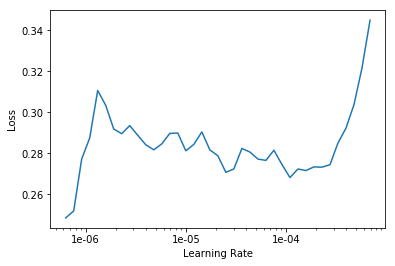

In [0]:
learner_50.recorder.plot()

In [0]:
learner_50.load(f"{data_path}/models/resnet50_with_donloaded_data")
learner_50.unfreeze()
learner_50.fit_one_cycle(20, max_lr=slice(1e-6, 1e-5))